In [1]:
import os, sys, time
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
pd.options.mode.chained_assignment = None
import h5py
import geopandas as gpd
os.sys.path.append(os.path.join(os.getcwd(),r'..\standard'))
import os, sys
sys.path.append(os.path.join(os.getcwd(),r'..\..\..'))
# import summary_helpers

%matplotlib inline

from IPython.display import display, HTML

if (sys.version_info < (3, 0)):
    HTML('''<script>
    code_show=true; 
    function code_toggle() {
     if (code_show){
     $('div.input').hide();
     } else {
     $('div.input').show();
     }
     code_show = !code_show
    } 
    $( document ).ready(code_toggle);
    </script>
    <form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
CSS = """
.output {
    flex-direction: row;
}
"""

HTML('<style>{}</style>'.format(CSS))

# Relative path between notebooks and goruped output directories
relative_path = '../../../outputs'
survey_path = '../../../inputs/base_year/survey'

In [3]:
pd.options.display.float_format = '{:0,.0f}'.format

In [4]:
def load_network_summary(filepath):
    """Load network-level results using a standard procedure. """
    df = pd.read_csv(filepath)

    # Congested network components by time of day
    df.columns

    # Get freeflow from 20to5 period

    # Exclude trips taken on non-designated facilities (facility_type == 0)
    # These are artificial (weave lanes to connect HOV) or for non-auto uses 
    df = df[df['data3'] != 0]    # data3 represents facility_type

    # calculate total link VMT and VHT
    df['VMT'] = df['@tveh']*df['length']
    df['VHT'] = df['@tveh']*df['auto_time']/60

    # Define facility type
    df.loc[df['data3'].isin([1,2]), 'facility_type'] = 'highway'
    df.loc[df['data3'].isin([3,4,6]), 'facility_type'] = 'arterial'
    df.loc[df['data3'].isin([5]), 'facility_type'] = 'connector'

    # Calculate delay
    # Select links from overnight time of day
    delay_df = df.loc[df['tod'] == '20to5'][['ij','auto_time']]
    delay_df.rename(columns={'auto_time':'freeflow_time'}, inplace=True)

    # Merge delay field back onto network link df
    df = pd.merge(df, delay_df, on='ij', how='left')

    # Calcualte hourly delay
    df['total_delay'] = ((df['auto_time']-df['freeflow_time'])*df['@tveh'])/60    # sum of (volume)*(travtime diff from freeflow)

    df['county'] =df['@countyid'].map({33: 'King',
                                      35: 'Kitsap',
                                      53: 'Pierce',
                                      61: 'Snohomish'})
    
    return df

# Truck Miles Traveled by Type
Daily Total

In [5]:
df = load_network_summary(os.path.join(relative_path,'network',r'network_results.csv'))

In [6]:
_df = df.groupby('county').sum()[['@medium_truck','@heavy_truck']]
_df.loc['Total',:] = _df.sum()
_df = _df.reset_index()
_df.rename(columns={'county':'County', '@medium_truck': 'Medium Trucks', '@heavy_truck': 'Heavy Trucks'}, inplace=True)
_df.to_csv(os.path.join(os.getcwd(), r'..\..\..\outputs\compare\RTP','truck_vmt.csv'))
HTML(_df.to_html(index=False))

County,Medium Trucks,Heavy Trucks
King,"16,242,990","9,436,199"
Kitsap,"866,303","410,810"
Pierce,"3,499,279","3,396,733"
Snohomish,"3,442,584","2,587,081"
Total,"24,051,156","15,830,823"


In [7]:
# Results by Congestion Level
df['speed'] = df['length']/df['auto_time']*60
df['congestion_index'] = df['speed']/df['data2']
df['congestion_index'] = df['congestion_index'].clip(0,1)
df['congestion_category'] = pd.cut(df['congestion_index'], bins=[0,.25,.5,.7,1], labels=['Severe','Heavy','Moderate','Light'])

AM Peak (5 - 9 am)

In [8]:
df['Medium and Heavy Trucks'] = df['@heavy_truck']+df['@medium_truck']

_df = df[df['tod'].isin(['5to6','6to7','7to8','8to9'])]
_df = _df.pivot_table(index='congestion_category',columns='county',
               aggfunc='sum',values='Medium and Heavy Trucks')
_df = _df.reindex(['Light','Moderate','Heavy','Severe'])
_df.index.name = None
_df.columns.name = None
_df.loc['Total',:] = _df.sum()
_df.to_csv(os.path.join(os.getcwd(), r'..\..\..\outputs\compare\RTP','truck_vmt_am.csv'))
_df

,King,Kitsap,Pierce,Snohomish
Light,"3,844,633","238,357","1,106,800","1,032,732"
Moderate,"849,259","11,695","212,868","155,516"
Heavy,"736,618","10,500","130,572","113,372"
Severe,"169,400","4,627","37,563","21,129"
Total,"5,599,910","265,178","1,487,803","1,322,750"


PM Peak (3 - 6 pm)

In [9]:
_df = df[df['tod'].isin(['15to16','16to17','17to18'])]
_df = _df.pivot_table(index='congestion_category',columns='county',
               aggfunc='sum',values='Medium and Heavy Trucks')
_df = _df.reindex(['Light','Moderate','Heavy','Severe'])
_df.index.name = None
_df.columns.name = None
_df.loc['Total',:] = _df.sum()
_df.to_csv(os.path.join(os.getcwd(), r'..\..\..\outputs\compare\RTP','truck_vmt_pm.csv'))
_df

,King,Kitsap,Pierce,Snohomish
Light,"3,054,994","205,635","869,754","810,778"
Moderate,"866,377","7,711","201,803","169,170"
Heavy,"715,154","6,768","155,867","128,789"
Severe,"200,164","4,803","35,818","22,639"
Total,"4,836,689","224,917","1,263,243","1,131,377"


# Share of Truck Miles by Truck Type
Daily Total

In [10]:
_df = df[['@medium_truck','@heavy_truck','county']].melt(
    id_vars='county', var_name='Truck Type')
_df = _df.pivot_table(index='Truck Type', columns='county', 
                values='value', aggfunc='sum')
_df.rename(index={'@heavy_truck': 'Heavy Trucks',
                 '@medium_truck': 'Medium Trucks'}, inplace=True)
_df.index.name = None
_df.columns.name = None
_df.sort_index(ascending=False, inplace=True)
_df_val = _df.copy()
_df.loc['Total',:] = _df.sum()
_df

,King,Kitsap,Pierce,Snohomish
Medium Trucks,"16,242,990","866,303","3,499,279","3,442,584"
Heavy Trucks,"9,436,199","410,810","3,396,733","2,587,081"
Total,"25,679,188","1,277,113","6,896,012","6,029,665"


In [11]:
pd.options.display.float_format = '{:0,.1%}'.format
_df_val/_df_val.sum()

,King,Kitsap,Pierce,Snohomish
Medium Trucks,63.3%,67.8%,50.7%,57.1%
Heavy Trucks,36.7%,32.2%,49.3%,42.9%


# Truck Miles on FGTS
Freight and Goods Transportation System
- T-1: More than 10 million tons per year
- T-2: 2 4 million to 10 million tons per year

In [12]:
pd.options.display.float_format = '{:0,.0f}'.format
_df = df[['@medium_truck','@heavy_truck','@fgts']].melt(
    id_vars='@fgts', var_name='Truck Type')
_df = _df.pivot_table(index='Truck Type', columns='@fgts', 
                values='value', aggfunc='sum')
# _df = _df.reset_index()
_df = _df.rename_axis(None, axis=1)
_df.rename(columns={0:'Other Routes', 1: 'T-1', 2: 'T-2'}, inplace=True)
_df.rename(index={'@heavy_truck': 'Heavy Trucks',
                 '@medium_truck': 'Medium Trucks'}, inplace=True)
_df[['T-1','T-2','Other Routes']]

,T-1,T-2,Other Routes
Truck Type,,,
Heavy Trucks,"10,820,632","1,803,744","3,256,474"
Medium Trucks,"8,887,238","4,743,816","10,420,114"


In [13]:
pd.options.display.float_format = '{:0,.1%}'.format
_df/_df.sum()

,Other Routes,T-1,T-2
Truck Type,,,
Heavy Trucks,23.8%,54.9%,27.5%
Medium Trucks,76.2%,45.1%,72.5%


In [14]:
pd.options.display.float_format = '{:0,.0f}'.format

# Congestion on FGTS
AM Peak (5 - 9 am)

In [15]:
# Congested Miles on FGTS versus other Routes
df['Medium and Heavy Trucks'] = df['@heavy_truck']+df['@medium_truck']

_df = df[df['tod'].isin(['5to6','6to7','7to8','8to9'])]
_df = _df.pivot_table(index='congestion_category',columns='@fgts',
               aggfunc='sum',values='Medium and Heavy Trucks')
_df = _df.reindex(['Light','Moderate','Heavy','Severe'])
_df.index.name = None
_df.columns.name = None
_df.rename(columns={0:'Other Routes', 1: 'T-1', 2: 'T-2'}, inplace=True)
_df_ = _df.copy()
_df.loc['Total',:] = _df.sum()
_df = _df[['T-1','T-2','Other Routes']]
_df

,T-1,T-2,Other Routes
Light,"2,729,514","1,066,910","2,436,756"
Moderate,"726,171","174,224","328,944"
Heavy,"570,992","146,147","273,923"
Severe,"56,242","54,688","121,793"
Total,"4,082,918","1,441,970","3,161,416"


In [16]:
pd.options.display.float_format = '{:0,.1%}'.format
_df_/_df_.sum()

,Other Routes,T-1,T-2
Light,77.1%,66.9%,74.0%
Moderate,10.4%,17.8%,12.1%
Heavy,8.7%,14.0%,10.1%
Severe,3.9%,1.4%,3.8%


PM Peak (3 - 6 pm)

In [17]:
pd.options.display.float_format = '{:0,.0f}'.format
# Congested Miles on FGTS versus other Routes
df['Medium and Heavy Trucks'] = df['@heavy_truck']+df['@medium_truck']

_df = df[df['tod'].isin(['15to16','16to17','17to18'])]
_df = _df.pivot_table(index='congestion_category',columns='@fgts',
               aggfunc='sum',values='Medium and Heavy Trucks')
_df = _df.reindex(['Light','Moderate','Heavy','Severe'])
_df.index.name = None
_df.columns.name = None
_df.rename(columns={0:'Other Routes', 1: 'T-1', 2: 'T-2'}, inplace=True)
_df_ = _df.copy()
_df.loc['Total',:] = _df.sum()
_df = _df[['T-1','T-2','Other Routes']]
_df

,T-1,T-2,Other Routes
Light,"1,998,045","881,725","2,070,156"
Moderate,"754,331","164,117","326,612"
Heavy,"589,531","153,072","263,975"
Severe,"72,180","61,169","130,078"
Total,"3,414,088","1,260,084","2,790,821"


In [18]:
pd.options.display.float_format = '{:0,.1%}'.format
_df_/_df_.sum()

,Other Routes,T-1,T-2
Light,74.2%,58.5%,70.0%
Moderate,11.7%,22.1%,13.0%
Heavy,9.5%,17.3%,12.1%
Severe,4.7%,2.1%,4.9%


# Households Within 500' of Heavy Truck Volumes
Total number of households within 500' of T-1 and T-2 routes
- T-1: More than 10 million tons per year
- T-2: 2 4 million to 10 million tons per year

In [19]:
# Intersect buffer with land use file
df_lu = pd.read_csv(r'..\..\..\inputs\scenario\landuse\parcels_urbansim.txt',
                   delim_whitespace=True)

# Load as a geodataframe
gdf_lu = gpd.GeoDataFrame(
    df_lu, geometry=gpd.points_from_xy(df_lu.XCOORD_P, df_lu.YCOORD_P))

crs = {'init' : 'EPSG:2285'}
gdf_lu.crs = crs

# Buffer the parcels at 500ft
gdf_lu['geometry'] = gdf_lu.buffer(500)

In [20]:

# Intersect this geography  with the network shapefile
gdf_network = gpd.read_file(r'..\..\..\inputs\scenario\networks\shapefiles\AM\AM_edges.shp')
# Do not include connectors since these are abstracted ul3==5; also remove weave links ul3==0 
gdf_network = gdf_network[~gdf_network.ul3.isin([0,5])]
# Truck network links are those that are in FGTS 1 or 2 system
gdf_network = gdf_network[gdf_network['FGTS'].isin([1,2])]

gdf_intersect = gpd.overlay(gdf_network, gdf_lu, how="intersection", keep_geom_type=False)

# Will need to relaculate the lengths since some were split across the regional geographies
gdf_intersect['new_length'] = gdf_intersect.geometry.length/5280.0

# filter out the polygon results and only keep lines
gdf_intersect = gdf_intersect[gdf_intersect.geometry.type.isin(['MultiLineString','LineString'])]

<AxesSubplot:>

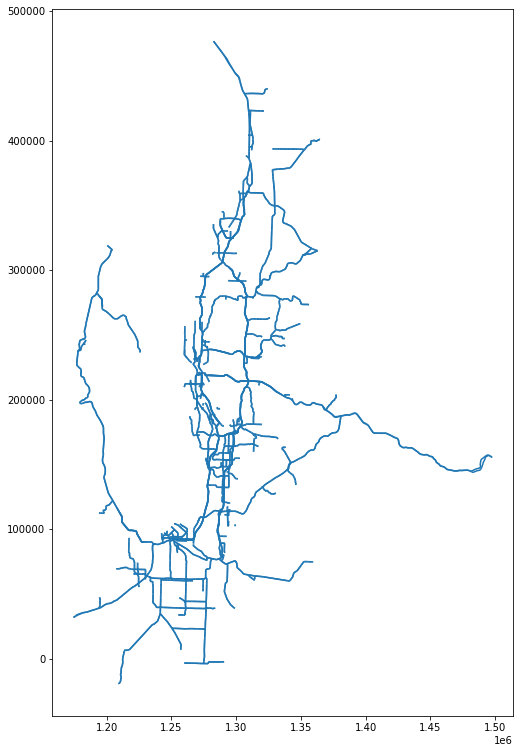

In [21]:
gdf_network.plot(figsize=(13,13))

In [22]:
truck_parcels = gdf_intersect.groupby('PARCELID').first()[['HH_P']].reset_index()


# Result should be the network components with some flags for the parcelid
# We can take the parcel information, join with parcel info and group
from input_configuration import base_year

parcel_geog = pd.read_sql_table('parcel_'+base_year+'_geography', 'sqlite:///../../../inputs/db/soundcast_inputs.db')
df = truck_parcels.merge(parcel_geog,left_on='PARCELID', right_on='ParcelID')

In [23]:
# md("There are **{}** total households within 500 feet of all T-1 and T-2 routes".format(int(df['HH_P'].sum())))
# df['HH_P'].sum()

In [24]:
# md("This is **{}**% of total regional households".format(str((df['HH_P'].sum()/df_lu['HH_P'].sum())*100)[:5]))

In [25]:
# Get the total number of households that in equtiy geograhpies
# Comprae the percent of those that are in the buffer versus those that are not
# For the 4 equity groups, perform the calc and add as a table
results_df = pd.DataFrame()
for col, name in {'racial_geog_vs_reg_total': 'Race',
                  'poverty_geog_vs_reg_total': 'Poverty',
                  'elderly_geog_vs_reg_total': 'Elderly',
                  'youth_geog_vs_reg_total': 'Youth'}.items():
    _df = df.groupby(col).sum()[['HH_P']]
    _df['equity_group'] = name
    results_df = results_df.append(_df)
results_df = results_df.reset_index()


Total Households Within 500' of T-1/T-2 Routes by Equity Group

In [26]:
_df = results_df.pivot_table(index='index', columns='equity_group', values='HH_P', aggfunc='sum')
_df.index = ['Households Not in Equity Geography', 'Households in Equity Geography']

% of households within 500' of truck routes that are in/outside of equity geographies

In [27]:
pd.options.display.float_format = '{:0,.1%}'.format
_df/_df.sum()

equity_group,Elderly,Poverty,Race,Youth
Households Not in Equity Geography,68.5%,49.0%,39.7%,65.0%
Households in Equity Geography,31.5%,51.0%,60.3%,35.0%


In [28]:
pd.options.display.float_format = '{:0,.0f}'.format

# results_df.groupby(['equity_group','index']).sum()[['HH_P']]
_df = results_df.pivot_table(index='equity_group',columns='index',values='HH_P')
_df.rename(columns={0:'Not In Equity Group', 1: 'In Equity Group'}, inplace=True)
_df.index.name = None
_df.columns.name = None
_df['Total Households'] = _df.sum(axis=1)
_df_buffer = _df.copy()


In [29]:
df_lu_tot = df_lu[['PARCELID','HH_P']].merge(parcel_geog,left_on='PARCELID', right_on='ParcelID')
# df_lu_tot['region'] = 1
results_df_tot = pd.DataFrame()
for col, name in {'racial_geog_vs_reg_total': 'Race',
                  'poverty_geog_vs_reg_total': 'Poverty',
                  'elderly_geog_vs_reg_total': 'Elderly',
                  'youth_geog_vs_reg_total': 'Youth',
#                   'region': 'Regional Total',
                 }.items():
    _df = df_lu_tot.groupby(col).sum()[['HH_P']]
    _df['equity_group'] = name
    results_df_tot = results_df_tot.append(_df)
results_df_tot = results_df_tot.reset_index()
pd.options.display.float_format = '{:0,.0f}'.format

results_df_tot = results_df_tot[results_df_tot['index'] >= 0]
_df = results_df_tot.pivot_table(index='equity_group',columns='index',values='HH_P')
_df.rename(columns={0:'Not in Equity Group', 1: 'In Equity Group'}, inplace=True)
_df.index.name = None
_df.columns.name = None
_df['Total Households'] = _df.sum(axis=1)
_df_tot = _df.copy()


Percent of Households in Equity Group Also in the Buffer

In [30]:
_df = _df_tot.merge(_df_buffer, left_index=True, right_index=True, suffixes=['_tot','_buffer'])

pd.options.display.float_format = '{:0,.1%}'.format
_df_compare = pd.DataFrame(_df['In Equity Group_buffer']/_df['In Equity Group_tot'], columns=['% of Total Households in Buffer'])
_df_compare.loc['All Households'] = (_df['Total Households_buffer']/_df['Total Households_tot'])[0]
_df_compare

,% of Total Households in Buffer
Elderly,6.7%
Poverty,12.1%
Race,13.5%
Youth,7.1%
All Households,10.0%
